## Learning to rank
* https://www.kaggle.com/code/raddar/learning-to-rank-time-related-features

* 本筋とは関係なさそう

* そうでもないか？「ランク学習」というものがあるらしい


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [30]:
from config import train_data_parquet
train = pd.read_parquet(train_data_parquet)

In [31]:
# train/val by customer_ID first symbol
fi = {'0':0,'1':0,'2':0,'3':0,'4':1,'5':1,'6':1,'7':1,'8':2,'9':2,'a':2,'b':2,'c':3,'d':3,'e':3,'f':3}
train['fold'] = train['customer_ID'].apply(lambda t: fi[t[0]])

In [32]:
# groupby.transform => groupby結果をいい感じに元のdfに割当 --
# 要はcount==13のやつだけtrainを抜いてきてる --
train = train.loc[train.groupby("customer_ID")["customer_ID"].transform("count")==13].reset_index(drop=True)

### ランクとは

In [33]:
# groupby.rank : 
# https://blog.pyq.jp/entry/pandas_drill_210608

train["rank"] = train.groupby("customer_ID")["S_2"].rank(ascending=False).astype(int)

gropuby(列名)[対象]
で、列名について対象が高いもの順にrank付け

In [34]:
train.loc[train["customer_ID"] == train.customer_ID[0], ["S_2", "rank"]]

,S_2,rank
0,2017-03-09,13
1,2017-04-07,12
2,2017-05-28,11
3,2017-06-13,10
4,2017-07-16,9
5,2017-08-04,8
6,2017-09-18,7
7,2017-10-08,6
8,2017-11-20,5
9,2017-12-04,4


### Training the model
* xgboostのrank:pairwiseモデルを作成

[0]	train-map:1.00000	valid-map:1.00000
[99]	train-map:1.00000	valid-map:1.00000


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

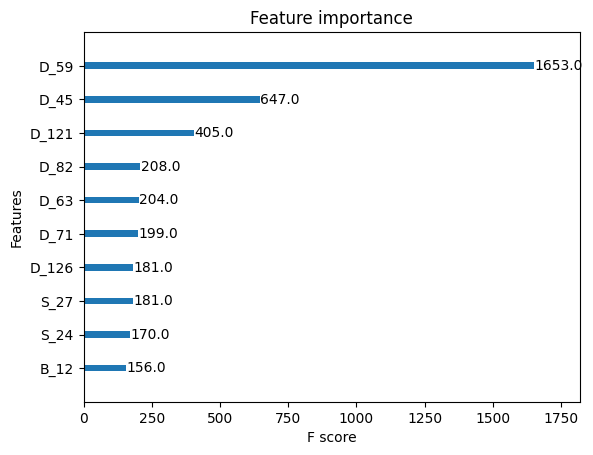

In [35]:
cols = [x for x in train.columns if x not in ("customer_ID", "fold", "S_2", "rank")]

tr = train.loc[train.fold==0].reset_index(drop=True)
dtrain = xgb.DMatrix(tr[cols], label=tr["rank"], group=tr.groupby("customer_ID").size().to_frame("size")["size"].to_numpy())

va = train.loc[train.fold==1].reset_index(drop=True)
dvalid = xgb.DMatrix(va[cols], label=va["rank"], group=va.groupby("customer_ID").size().to_frame("size")["size"].to_numpy())

del train

model = xgb.train(
    {
        "tree_method": "gpu_hist",
        "objective": "rank:pairwise",
        "subsample": 1,
        "colsample_bytree": 1,
    },
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    num_boost_round=100,
    verbose_eval=100,
    maximize=True
)

plot_importance(model, max_num_features=10, grid=False)

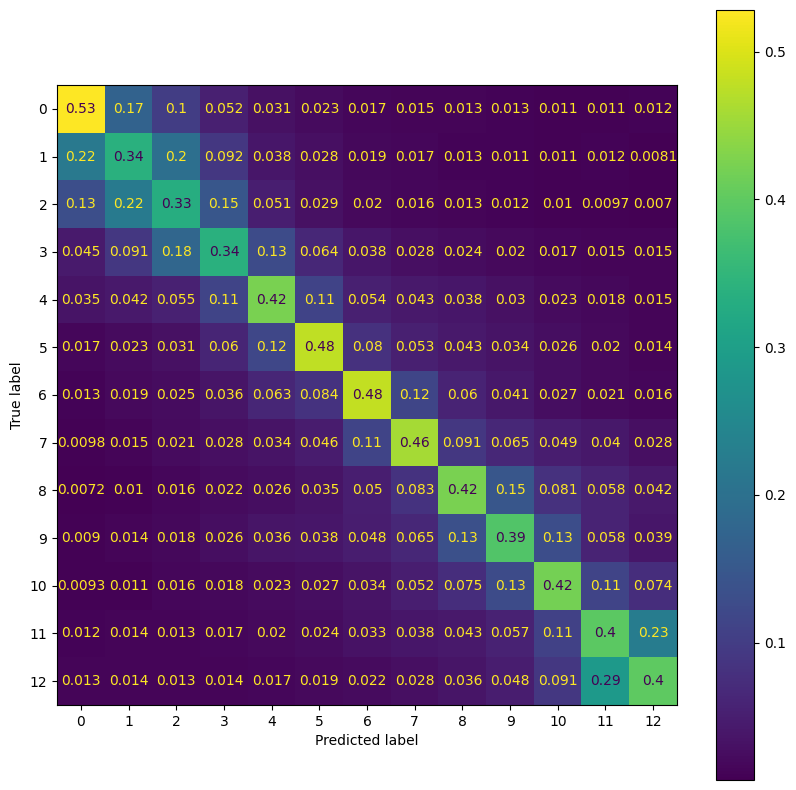

In [36]:
va["pred"] = model.predict(dvalid)
va["rank_pred"] = va.groupby("customer_ID")["pred"].rank().astype(int)

cm = confusion_matrix(va["rank"], va["rank_pred"], normalize="true")
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10, 10))
cmp.plot(ax=ax)

### Understanding D_59

In [42]:
pd.set_option("display.max_rows", 100)
va[["customer_ID", "rank", "rank_pred", "D_59"]].head(13*3)

,customer_ID,rank,rank_pred,D_59
0,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,13,12,21
1,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,12,12,21
2,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,11,11,22
3,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,10,10,23
4,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,9,9,24
5,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,8,8,25
6,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,7,7,26
7,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,6,6,28
8,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,5,5,29
9,400013f52d6cda9080b81bad65d8c2dad10d188fc3d24e...,4,3,30


In [45]:
gg = va.loc[va.D_59!=-1].groupby("customer_ID")["D_59"].agg(("max", "min")).reset_index()
s1 = gg.loc[gg["max"] - gg["min"] > 9].reset_index(drop=True)
s2 = gg.loc[gg["max"] - gg["min"] <= 9].reset_index(drop=True)

s1.shape, s2.shape

((39910, 3), (56784, 3))

### D_59の時間的な振る舞いによってrankの推定精度が2~3倍違うよ、ということの図示
* 正直よくわからず...

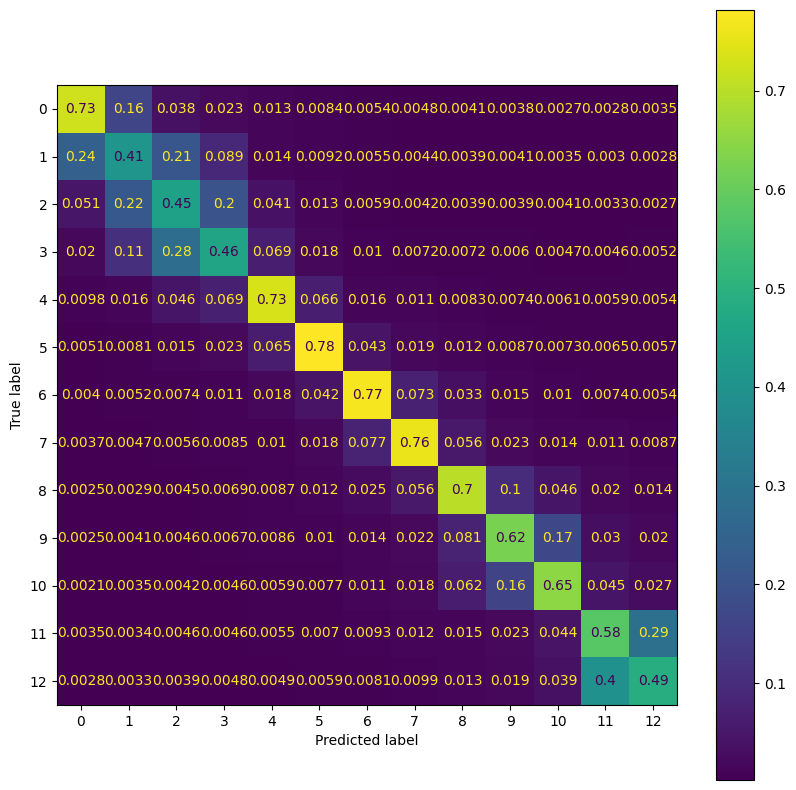

In [47]:
seg = va.loc[va.customer_ID.isin(s1.customer_ID)]
cm = confusion_matrix(seg["rank"], seg["rank_pred"], normalize="true")
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10, 10))
cmp.plot(ax=ax)

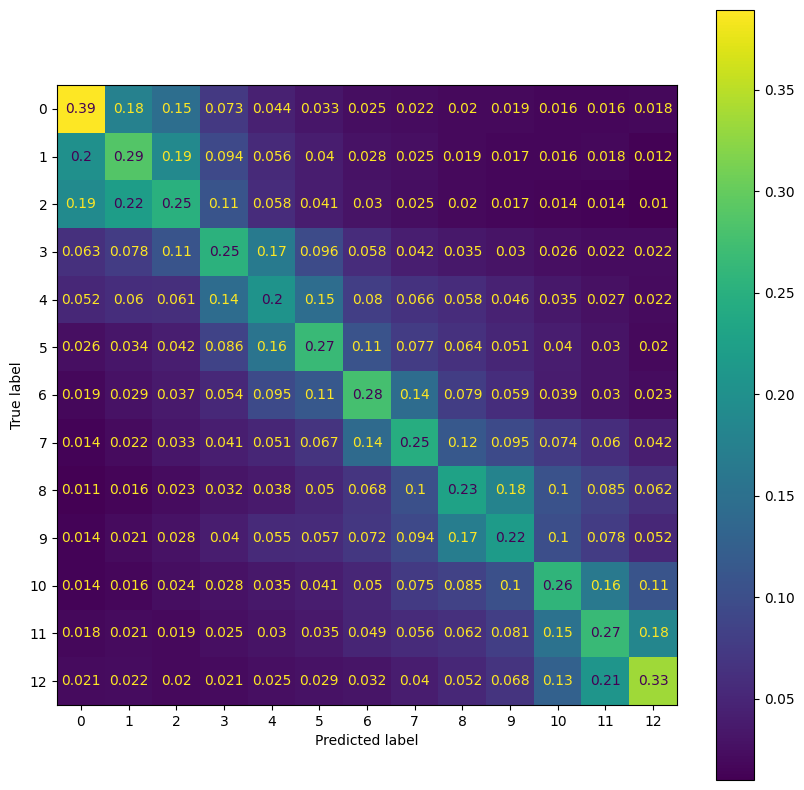

In [48]:
seg = va.loc[va.customer_ID.isin(s2.customer_ID)]
cm = confusion_matrix(seg["rank"], seg["rank_pred"], normalize="true")
cmp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10, 10))
cmp.plot(ax=ax)